<a href="https://colab.research.google.com/github/yoonni0908/NLP/blob/main/TitleGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [2]:
import sys
import os
root_dir = "/gdrive/MyDrive/NLP/week12/12-2. Pretrained LM2"
sys.path.append(root_dir)

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.4 MB/s eta 0:00:00


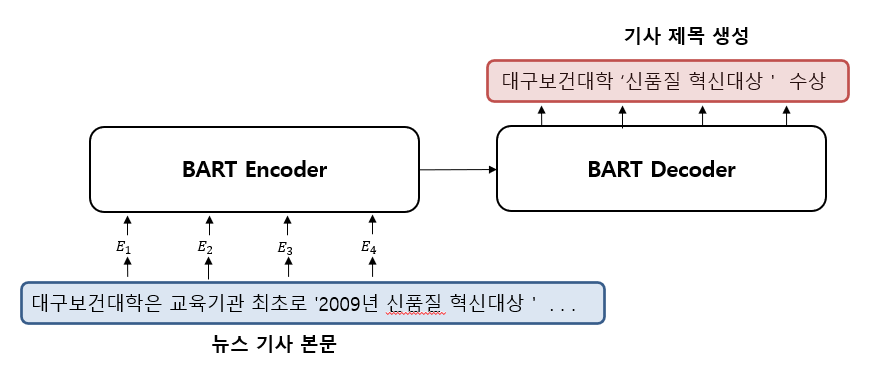

In [4]:
from IPython.display import Image
Image(os.path.join(root_dir, "TitleGeneration.PNG"))

In [5]:
import logging

import os
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, RandomSampler
from transformers import AdamW
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

def read_data(file_path):
    datas = []
    with open(file_path, "r", encoding="utf8") as infile:
        for line in infile:
          # 입력 데이터를 \t을 기준으로 분리
          pieces = line.strip().split("\t")
          article, title = pieces[0], pieces[1]
          datas.append((article, title))

    return datas


def convert_data2feature(datas, max_length, max_dec_length, tokenizer):
    input_ids_features, attention_mask_features, decoder_input_features, decoder_attention_mask_features, label_features = [], [], [], [], []

    for article, title in tqdm(datas, desc="convert_data2feature"):
        # tokenizer를 사용하여 입력 문장을 word piece 단위로 분리
        tokenized_article = tokenizer.tokenize(article)
        tokenized_title= tokenizer.tokenize(title)

        #########################################
        
        
        input_ids = tokenizer.convert_tokens_to_ids(tokenized_article)
        attention_mask = [1] * len(input_ids)

        decoder_input = tokenizer.convert_tokens_to_ids(['<s>'] + tokenized_title)
        decoder_attention_mask = [1] * len(decoder_input)
        label = tokenizer.convert_tokens_to_ids(tokenized_title + ['</s>'])

        #########################################


        # 변환한 데이터를 각 리스트에 저장
        input_ids_features.append(input_ids[:max_length] + [0]*(max_length - len(input_ids)))
        attention_mask_features.append(attention_mask[:max_length] + [0]*(max_length - len(attention_mask)))
        decoder_input_features.append(decoder_input[:max_dec_length] + [0]*(max_dec_length - len(decoder_input)))
        decoder_attention_mask_features.append(decoder_attention_mask[:max_dec_length] + [0]*(max_dec_length-len(decoder_attention_mask)))
        label_features.append(label[:max_dec_length] + [0]*(max_dec_length - len(label)))

    # 변환한 데이터를 Tensor 객체에 담아 반환
    input_ids_features = torch.tensor(input_ids_features, dtype=torch.long)
    attention_mask_features = torch.tensor(attention_mask_features, dtype=torch.long)
    decoder_input_features = torch.tensor(decoder_input_features, dtype=torch.long)
    decoder_attention_mask_features = torch.tensor(decoder_attention_mask_features, dtype=torch.long)
    label_features = torch.tensor(label_features, dtype=torch.long)

    return input_ids_features, attention_mask_features, decoder_input_features, decoder_attention_mask_features, label_features

def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [6]:
logger = logging.getLogger(__name__)
from torch.utils.data import (DataLoader, TensorDataset, RandomSampler, SequentialSampler)
from transformers import BartForConditionalGeneration
from transformers import PreTrainedTokenizerFast
def train(config):
    tokenizer = PreTrainedTokenizerFast.from_pretrained(config["pretrained_model_name_or_path"])
    model = BartForConditionalGeneration.from_pretrained(config["pretrained_model_name_or_path"]).cuda()
    """ Train the model """
    # 학습 및 평가 데이터 읽기
    train_datas = read_data(config["train_data_path"])
    test_datas = read_data(config["test_data_path"])

    # 입력 데이터 전처리
    train_input_ids_features, train_attention_mask_features, train_decoder_input_features, train_decoder_attention_mask_features, train_label_features = \
        convert_data2feature(train_datas, config["max_length"],config["max_dec_length"], tokenizer)
    test_input_ids_features, test_attention_mask_features, test_decoder_input_features, test_decoder_attention_mask_features, test_label_features = \
        convert_data2feature(test_datas, config["max_length"], config["max_dec_length"], tokenizer)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_input_ids_features, train_attention_mask_features, train_decoder_input_features, train_decoder_attention_mask_features, train_label_features)
    train_dataloader = DataLoader(train_features, sampler=RandomSampler(train_features),
                                  batch_size=config["batch_size"])

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_input_ids_features, test_attention_mask_features, test_decoder_input_features, test_decoder_attention_mask_features, test_label_features)
    test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features),
                                 batch_size=config["batch_size"])

    # 모델 학습을 위한 optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
    global_step = 1

    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()

    set_seed(config["seed"])

    for epoch in range(config["epoch"]):
        for step, batch in enumerate(train_dataloader):
            # Skip past any already trained steps if resuming training
            model.train()
            batch = tuple(t.cuda() for t in batch)
            outputs = model(input_ids=batch[0],
                              attention_mask=batch[1],
                              decoder_input_ids=batch[2],
                              decoder_attention_mask=batch[3],
                              labels=batch[4],
                                return_dict=True)

            loss = outputs["loss"]

            loss.backward()
            if (global_step+1) % 50 == 0:
                print("{} Processed.. Total Loss : {}".format(global_step+1, loss.item()))

            tr_loss += loss.item() # 텐서에서 스칼라 값을 추출하는 방법 

            optimizer.step()
            model.zero_grad()
            global_step += 1

            # Save model checkpoint
            if global_step % 500 == 0:
                evaluate(config, model, tokenizer, test_dataloader)

                output_dir = os.path.join(config["output_dir_path"], "checkpoint-{}".format(global_step))
                print("Model Save in {}".format(output_dir))
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)

                # Take care of distributed/parallel training
                model_to_save = model.module if hasattr(model, "module") else model
                model_to_save.save_pretrained(output_dir)

    return global_step, tr_loss / global_step

def evaluate(config, model, tokenizer, test_dataloader):
    model.eval()
    for batch in tqdm(test_dataloader):
        batch = tuple(t.cuda() for t in batch)

        dec_outputs = model.generate(input_ids = batch[0], # 생성을 위한 별도의 함수 제공
                                     attention_mask=batch[1],
                                     max_length=config["max_dec_length"],
                                     eos_token_id=1, # </s>
                                     do_sample=False, # Greedy search 할 것인지 Sampling할 것인지 여부
                                     bad_words_ids=[[5]] # 나쁜말 생성 금지 
                                    )

        batch_size = batch[0].size()[0]

        dec_outputs = dec_outputs.tolist()
        dec_labels = batch[4].tolist()
      
        # 
        for index in range(batch_size):
            if 1 in dec_outputs[index]: # 처음부터 EOS까지만 끊어오기
                dec_outputs[index] = dec_outputs[index]
            if -100 in dec_labels[index]:
                dec_labels[index] = dec_labels[index][:dec_labels[index].index(-100)] # 처음부터 Padding index까지만 끊어오기
            else:
                dec_labels[index] = dec_labels[index] 
            pred = "".join(tokenizer.convert_ids_to_tokens(dec_outputs[index][1:])).replace("Ġ", " ").replace("<pad>", "").replace("</s>", "").replace("▁", " ")
            ref = "".join(tokenizer.convert_ids_to_tokens(dec_labels[index][:-1])).replace("Ġ", " ").replace("<pad>", "").replace("</s>", "").replace("▁", " ")

            print("REFERENCE : {}\nDECODED   : {}\n".format(ref, pred))

            #  


In [ ]:
if (__name__ == "__main__"):
    save_dir = os.path.join(root_dir, "save")
    output_dir = os.path.join(root_dir, "output")
    cache_dir = os.path.join(root_dir, "cache")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    set_seed(seed=1234)

    config = {"mode": "train",
              "train_data_path": os.path.join(root_dir, "train.txt"),
              "test_data_path": os.path.join(root_dir, "test.txt"),
              "output_dir_path": output_dir,
              "save_dir_path": save_dir,
              "cache_dir_path": cache_dir,
              "pretrained_model_name_or_path": "hyunwoongko/kobart",
              "max_length": 250,
              "max_dec_length": 60,
              "epoch": 30,
              "batch_size": 16,
              "seed": 42,
              }

    if (config["mode"] == "train"):
        train(config)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


convert_data2feature:  79%|███████▉  | 12251/15414 [00:15<00:05, 547.64it/s]